In [150]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [151]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
RES = os.path.join(ROOT,'results')

In [152]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import torchvision
from torchsummary import summary

from wtsgd import *
from mnist_archs import LeNet
from tqdm import tqdm

import pickle
from time import time
import numpy as np
np.seed = 1101
from matplotlib import pyplot as plt
plt.style.use('ggplot')

In [153]:
DATASET = 'cifar10'
mb_size    = 10         # mini-batch size (default : 10)
n          = 300        # number of mini-batches in a large batch
lb_size    = n*mb_size  # large batch size (after this gradient update with modified SGD rule)  
n_lb       = int(50000.0/(lb_size)) # number of large batches in a epoch
epochs     = 100
lr         = 0.1
momentum   = 0.0    
mean_imgs  = (0.5,0.5,0.5)
std_imgs   = (0.5,0.5,0.5)
imgs_shape = (3,32,32)

In [154]:
import os
ROOT = '/home/ansuini/repos/WellTemperedSGD/'
os.chdir(ROOT)

In [155]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
kwargs = {'num_workers': 2, 'pin_memory': True} if device.type == 'cuda' else {}
print('Device : {}'.format( device ) )

Device : cuda:0


In [156]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean_imgs, std_imgs)])

trainset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=mb_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(ROOT +  '/data/' + DATASET, train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=mb_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [157]:
def imshow(img):
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.xticks([])
    plt.yticks([])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([10, 3, 32, 32])


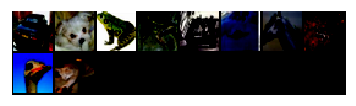

In [158]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images))
print(images.shape)

In [159]:
from cifar10_archs import Net
model = Net()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [160]:
grad  = init_grad(model)
grad2 = init_grad(model)  
print(grad[0][0][0])
print(grad2[0][0][0])

tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]], device='cuda:0')
tensor([[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]], device='cuda:0')


In [161]:
inputs, labels = dataiter.next()
inputs = inputs.to(device)
labels = labels.to(device)     

In [162]:
print(inputs.shape)
print(labels.shape)

torch.Size([10, 3, 32, 32])
torch.Size([10])


In [163]:
# zero the parameter gradients
optimizer.zero_grad()      

In [164]:
# forward
outputs = model(inputs)

In [165]:
# loss computation
loss = criterion(outputs, labels)
print(loss)

tensor(2.2935, device='cuda:0')


In [166]:
# compute the grad
loss.backward()

In [167]:
# show gradient
with torch.no_grad():
    for p in model.parameters(): 
        if len(list(p.grad.size())) == 4:
            print('Par : {}'.format( p[0,0,0,0]) )
            print('Grad : {}'.format( p.grad[0,0,0,0]) )

Par : -0.019195161759853363
Grad : 0.0004487727419473231
Par : 0.07806044816970825
Grad : -0.0008843161049298942


In [168]:
# accumulate grad and grad2
grad  = acc_grad(grad,model)
grad2 = acc_grad2(grad2,model)

In [169]:
# show gradient
with torch.no_grad():
    for g, g2 in zip( grad, grad2): 
        if len(list(g.size())) == 4:
            print(g[0,0,0,0])
            print(g2[0,0,0,0])          
            # only the first time
            np.testing.assert_array_equal( g2.cpu().numpy(),  (g**2).cpu().numpy() ) 

tensor(1.00000e-04 *
       4.4877, device='cuda:0')
tensor(1.00000e-07 *
       2.0140, device='cuda:0')
tensor(1.00000e-04 *
       -8.8432, device='cuda:0')
tensor(1.00000e-07 *
       7.8201, device='cuda:0')


In [259]:
n = 10

In [260]:
# init accumulators grad and grad2
grad  = init_grad(model)
grad2 = init_grad(model) 

In [261]:
for i, data in enumerate(train_loader, 0):

    # get the inputs
    inputs, labels = data
    inputs = inputs.to(device)
    labels = labels.to(device)  

    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward
    outputs = model(inputs)
    loss = criterion(outputs, labels)        
    # compute the grad
    loss.backward()

    # accumulate grad and grad2
    grad  = acc_grad(grad,model)
    grad2 = acc_grad2(grad2,model)

    
    if (i + 1) % n == 0 :             
        # compute the snr 
        snr = compute_snr(grad, grad2, n, mb_size)
        break  

In [262]:
snr[0] <= 1

tensor([[[[ 1,  1,  1,  1,  1],
          [ 1,  1,  1,  1,  1],
          [ 1,  1,  1,  1,  1],
          [ 1,  1,  0,  0,  1],
          [ 1,  0,  0,  0,  1]],

         [[ 1,  1,  1,  1,  1],
          [ 1,  1,  0,  1,  1],
          [ 1,  1,  0,  0,  1],
          [ 1,  0,  0,  0,  0],
          [ 1,  0,  0,  0,  0]],

         [[ 1,  1,  0,  1,  0],
          [ 1,  1,  0,  1,  0],
          [ 1,  1,  0,  0,  0],
          [ 1,  1,  0,  0,  0],
          [ 1,  0,  0,  0,  0]]],


        [[[ 1,  1,  0,  0,  0],
          [ 1,  0,  0,  0,  0],
          [ 1,  1,  0,  0,  1],
          [ 1,  1,  1,  1,  1],
          [ 1,  1,  1,  1,  1]],

         [[ 1,  0,  0,  0,  0],
          [ 1,  0,  0,  0,  0],
          [ 1,  0,  0,  0,  0],
          [ 1,  0,  0,  0,  0],
          [ 0,  0,  0,  1,  1]],

         [[ 1,  0,  0,  0,  0],
          [ 0,  0,  0,  0,  0],
          [ 1,  0,  0,  0,  0],
          [ 0,  0,  0,  0,  0],
          [ 0,  0,  0,  0,  1]]],


        [[[ 1,  1,  1,  

In [263]:
MODIFIED_SGD = True
with torch.no_grad():
    for p, g, s in zip(model.parameters(), grad, snr):                     
        # average the grad                            
        # this is the only line where the true gradient is touched
        if MODIFIED_SGD:
            p.grad = torch.where(s >= 1, g/n, s * g/n)          
        else:
            p.grad = g/n

In [270]:
with torch.no_grad():
    for p, g, s in zip(model.parameters(), grad, snr):                     
        a = ( (p.grad - g/n ).abs().cpu() > 0 ).numpy()
        b = ( s.cpu() < 1 ).numpy()
        
        
        print((p.grad - g/n)[0][0] )
        print( (s >= 1)[0][0] ) 
        
        

tensor(1.00000e-04 *
       [[ 0.8778,  1.6197,  1.3887,  1.3856,  1.6049],
        [-0.1749,  1.1892,  0.6802,  1.3186,  0.5109],
        [-0.7057,  0.4674,  0.8066,  0.9285,  1.2018],
        [ 1.6640,  0.2765,  0.0000,  0.0000,  1.2604],
        [ 1.6990,  0.0000,  0.0000,  0.0000,  0.8007]], device='cuda:0')
tensor([[ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  0,  0,  0],
        [ 0,  0,  1,  1,  0],
        [ 0,  1,  1,  1,  0]], dtype=torch.uint8, device='cuda:0')
tensor(1.00000e-04 *
       1.8316, device='cuda:0')
tensor(0, dtype=torch.uint8, device='cuda:0')
tensor(1.00000e-04 *
       [[-0.5109,  1.2412,  0.0627, -0.4502,  0.0000],
        [-1.0690, -0.8075, -0.9945, -1.2674, -1.1157],
        [ 0.0000,  0.0000, -0.3018,  0.0000, -0.8686],
        [ 0.0000,  0.0000,  0.0000, -0.8874, -1.0082],
        [-0.8841,  0.0000,  0.0000, -0.1907, -0.7022]], device='cuda:0')
tensor([[ 0,  0,  0,  0,  1],
        [ 0,  0,  0,  0,  0],
        [ 1,  1,  0,  1,  

/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:7: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  import sys
/home/ansuini/.local/envs/pytorch/lib/python3.5/site-packages/ipykernel_launcher.py:8: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  
